In [0]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.externals.six import StringIO 
from IPython.display import Image
from operator import itemgetter
import graphviz
import pydotplus
from typing import Dict, Tuple
from scipy import stats
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

In [2]:
# В качестве набора данных будем использовать diamonds dataset
diamonds = pd.read_csv('diamonds.csv', sep=",", encoding='ISO-8859-1')
diamonds.drop(diamonds.columns[[0]], axis='columns', inplace = True)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [0]:
# Кодирование категориального признака cut
le = LabelEncoder()
cat_enc_le = le.fit_transform(diamonds['cut'])
cut = pd.DataFrame({'cut':cat_enc_le.T})

In [0]:
# Кодирование категориального признака color
cat_enc_le1 = le.fit_transform(diamonds['color'])
color = pd.DataFrame({'color':cat_enc_le1.T})

In [0]:
# Кодирование категориального признака clarity
cat_enc_le2 = le.fit_transform(diamonds['clarity'])
clarity = pd.DataFrame({'clarity':cat_enc_le2.T})

In [6]:
# Заменим значения категориальных признаков в наборе данных
del diamonds['cut']
del diamonds['color']
del diamonds['clarity']
diamonds = diamonds.join(cut)
diamonds = diamonds.join(color)
diamonds = diamonds.join(clarity)
diamonds

,carat,depth,table,price,x,y,z,cut,color,clarity
0,0.23,61.5,55.0,326,3.95,3.98,2.43,2,1,3
1,0.21,59.8,61.0,326,3.89,3.84,2.31,3,1,2
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,1,4
3,0.29,62.4,58.0,334,4.20,4.23,2.63,3,5,5
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,6,3
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,2,0,2
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,1,0,2
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,4,0,2
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,3,4,3


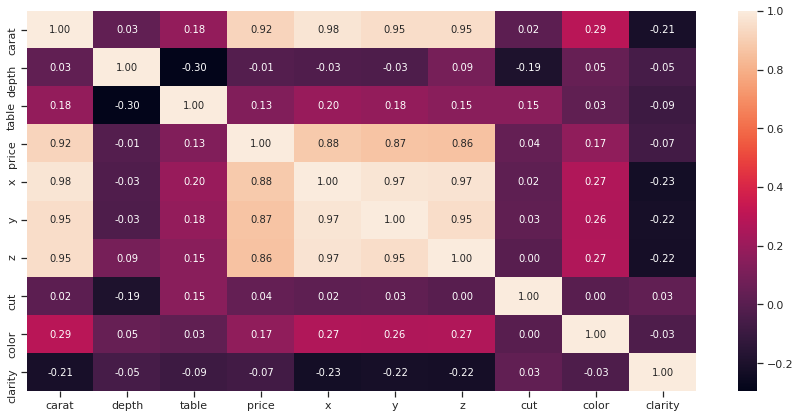

In [12]:
# Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(diamonds.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

In [7]:
# Так как параметры x, y и z определяют признак carat, их можно не учитывать при дальнейшем анализе
diamonds_new = diamonds.drop(columns=['y','z','x'])

# Отмасштабируем данные, чтобы получить корректные оценки качества моделей
scal= MinMaxScaler()
s = scal.fit_transform(diamonds_new)
diamonds_new = pd.DataFrame(s, columns= ['carat',	'depth',	'table',	'price',	'cut',	'color',	'clarity'])
diamonds_new

,carat,depth,table,price,cut,color,clarity
0,0.006237,0.513889,0.230769,0.000000,0.50,0.166667,0.428571
1,0.002079,0.466667,0.346154,0.000000,0.75,0.166667,0.285714
2,0.006237,0.386111,0.423077,0.000054,0.25,0.166667,0.571429
3,0.018711,0.538889,0.288462,0.000433,0.75,0.833333,0.714286
4,0.022869,0.563889,0.288462,0.000487,0.25,1.000000,0.428571
...,...,...,...,...,...,...,...
53935,0.108108,0.494444,0.269231,0.131427,0.50,0.000000,0.285714
53936,0.108108,0.558333,0.230769,0.131427,0.25,0.000000,0.285714
53937,0.103950,0.550000,0.326923,0.131427,1.00,0.000000,0.285714
53938,0.137214,0.500000,0.288462,0.131427,0.75,0.666667,0.428571


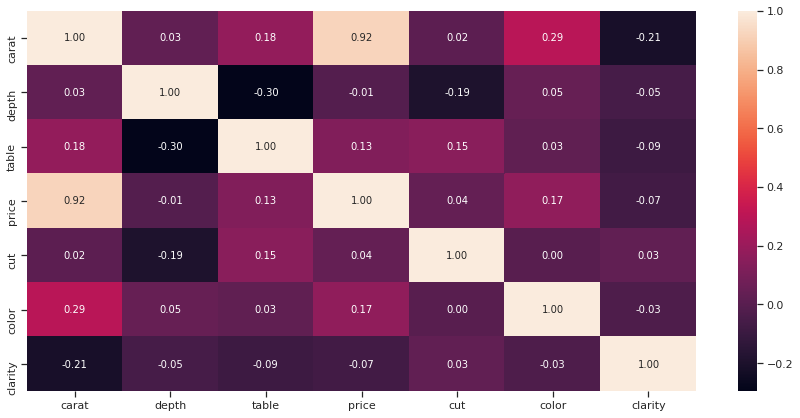

In [17]:
# Снова построим корреляционную матрицу - для отмасштабированных данных
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(diamonds_new.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

Из корреляционной матрицы следует, что целевой признак ('price') наиболее выраженно коррелирует с признаком 'carat', что говорит о необходимости его использования при построении моделей обучения. Так как признаки x, y и z сильно коррелировали (см. матрицу корреляций исходных данных) с признаком 'carat', мы исключили их из дальнейшего рассмотрения.

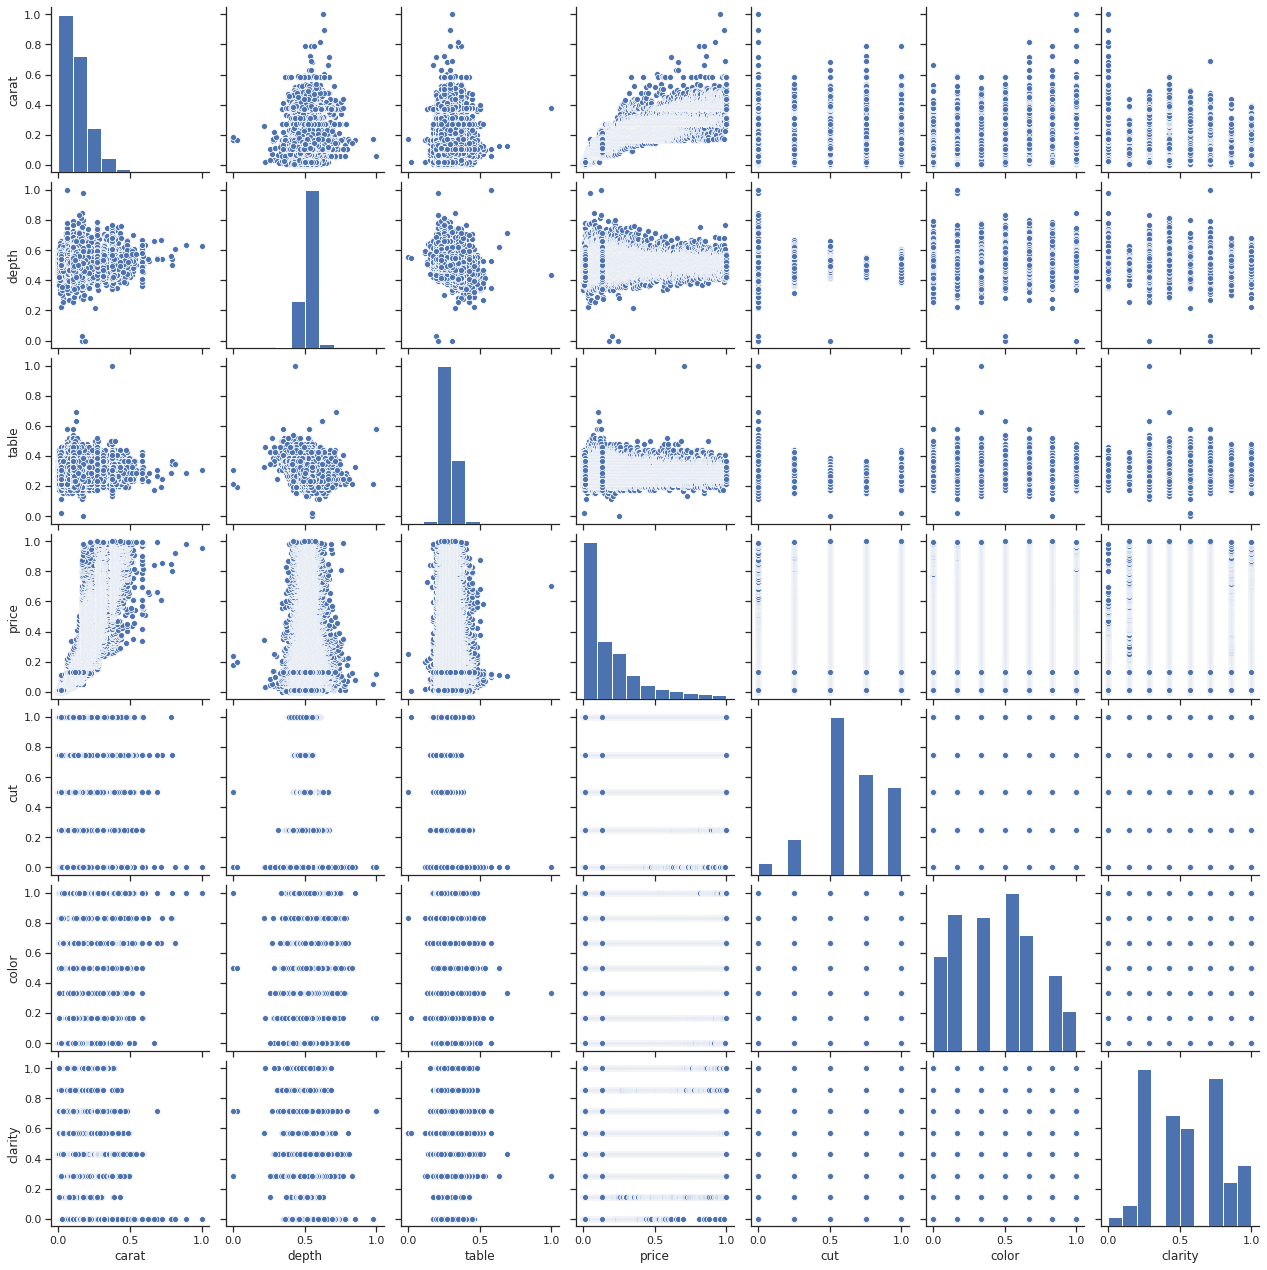

In [14]:
# Построим некоторые графики для понимания структуры данных
# Парные диаграммы
sns.pairplot(diamonds_new)

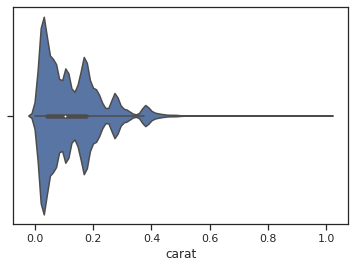

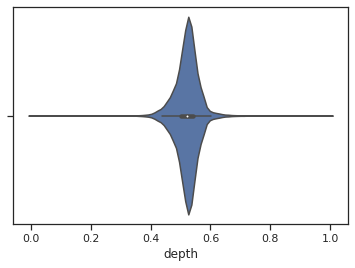

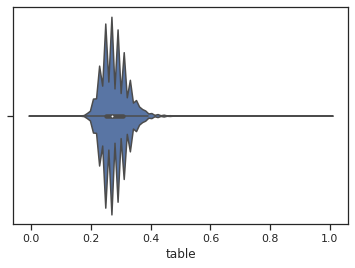

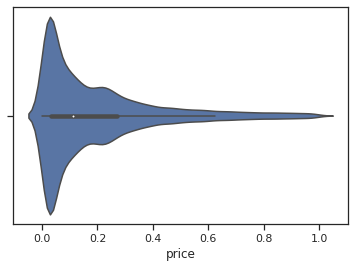

In [16]:
# Скрипичные диаграммы для числовых колонок
for col in ['carat', 'depth', 'table', 'price']:
    sns.violinplot(x=diamonds_new[col])
    plt.show()

In [10]:
# Разделим набор данных на обучающую и тестовую выборки
X_diam = diamonds_new.drop(columns='price')
y_diam = diamonds_new.price
X_train, X_test, y_train, y_test = train_test_split(X_diam, y_diam, test_size = 0.2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((43152, 6), (10788, 6), (43152,), (10788,))

В качестве метрик для решения задачи регрессии будем использовать следующие метрики:
- Mean absolute error (средняя абсолютная ошибка);
- Mean squared error (средняя квадратичная ошибка);
- Метрика R2 (коэффициент детерминации).

In [0]:
# Класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()

Для задачи регрессии будем использовать следующие модели:
- Метод ближайших соседей
- Машина опорных векторов
- Градиентный бустинг

In [19]:
# Выборки для задачи регресии
regr_X_train = X_train
regr_X_test = X_test
regr_Y_train = y_train
regr_Y_test = y_test
regr_X_train.shape, regr_X_test.shape, regr_Y_train.shape, regr_Y_test.shape

((43152, 6), (10788, 6), (43152,), (10788,))

Построим базовое решение (baseline) для выбранных моделей без подбора гиперпараметров. Произведём обучение моделей на основе обучающей выборки и оценку качества моделей на основе тестовой выборки.

In [0]:
# Модели
regr_models = {'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),               
               'GB':GradientBoostingRegressor()}

In [0]:
# Сохранение метрик
regrMetricLogger = MetricLogger()

In [0]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(regr_X_train, regr_Y_train)
    Y_pred = model.predict(regr_X_test)
    
    mae = mean_absolute_error(regr_Y_test, Y_pred)
    mse = mean_squared_error(regr_Y_test, Y_pred)
    r2 = r2_score(regr_Y_test, Y_pred)

    regrMetricLogger.add('MAE', model_name, mae)
    regrMetricLogger.add('MSE', model_name, mse)
    regrMetricLogger.add('R2', model_name, r2)    
    
    print('*****************************************************')
    print(model)
    print()
    print('MAE={}, MSE={}, R2={}'.format(
        round(mae, 3), round(mse, 3), round(r2, 3)))
    print('*****************************************************')

In [25]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

MAE=0.022, MSE=0.002, R2=0.962
*****************************************************
*****************************************************
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE=0.045, MSE=0.004, R2=0.923
*****************************************************
*****************************************************
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_s

Произведём подбор гиперпараметров для выбранных моделей.

In [26]:
# Для модели "Метод ближайших соседей"
n_range = np.array(range(1,25,3))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22])}]

In [27]:
regr_gs_KN = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs_KN.fit(regr_X_train, regr_Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=None,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_neighbors': array([ 1,  4,  7, 10, 13, 16, 19, 22])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [28]:
# Лучшая модель
regr_gs_KN.best_estimator_

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

In [29]:
# Лучшее значение параметров
regr_gs_KN.best_params_

{'n_neighbors': 4}

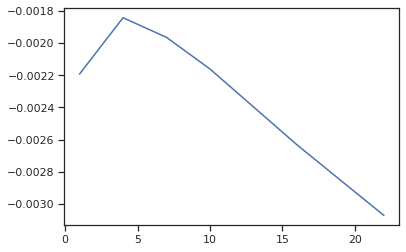

In [30]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, regr_gs_KN.cv_results_['mean_test_score'])

In [34]:
# Для модели "Машина опорных векторов"
n_range1 = np.array(range(1,10,2))
tuned_parameters = [{'degree': n_range1}]
tuned_parameters

[{'degree': array([1, 3, 5, 7, 9])}]

In [35]:
regr_gs_SVR = GridSearchCV(SVR(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs_SVR.fit(regr_X_train, regr_Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'degree': array([1, 3, 5, 7, 9])}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [36]:
# Лучшая модель
regr_gs_SVR.best_estimator_

SVR(C=1.0, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [37]:
# Лучшее значение параметров
regr_gs_SVR.best_params_

{'degree': 1}

In [39]:
# Для модели "Градиентный бустинг"
n_range = np.array(range(1,10,1))
tuned_parameters = [{'max_depth': n_range}]
tuned_parameters

[{'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}]

In [40]:
regr_gs_GBR = GridSearchCV(GradientBoostingRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs_GBR.fit(regr_X_train, regr_Y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_no_change=None,
                 

In [41]:
# Лучшая модель
regr_gs_GBR.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [42]:
# Лучшие параметры
regr_gs_GBR.best_params_

{'max_depth': 7}

Повторим обучение моделей для найденных оптимальных значений гиперпараметров.

In [0]:
regr_models_grid = {'KNN_4':regr_gs_KN.best_estimator_,
                    'SVR':regr_gs_SVR.best_estimator_,
                    'GBR' : regr_gs_GBR.best_estimator_,
                    }

In [44]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

*****************************************************
KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                    weights='uniform')

MAE=0.022, MSE=0.002, R2=0.963
*****************************************************
*****************************************************
SVR(C=1.0, cache_size=200, coef0=0.0, degree=1, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

MAE=0.045, MSE=0.004, R2=0.923
*****************************************************
*****************************************************
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_s

Характеристики качества работы моделей улучшились.

Формирование выводов о качестве построенных моделей.

In [45]:
# Метрики качества модели
regr_metrics = regrMetricLogger.df['metric'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

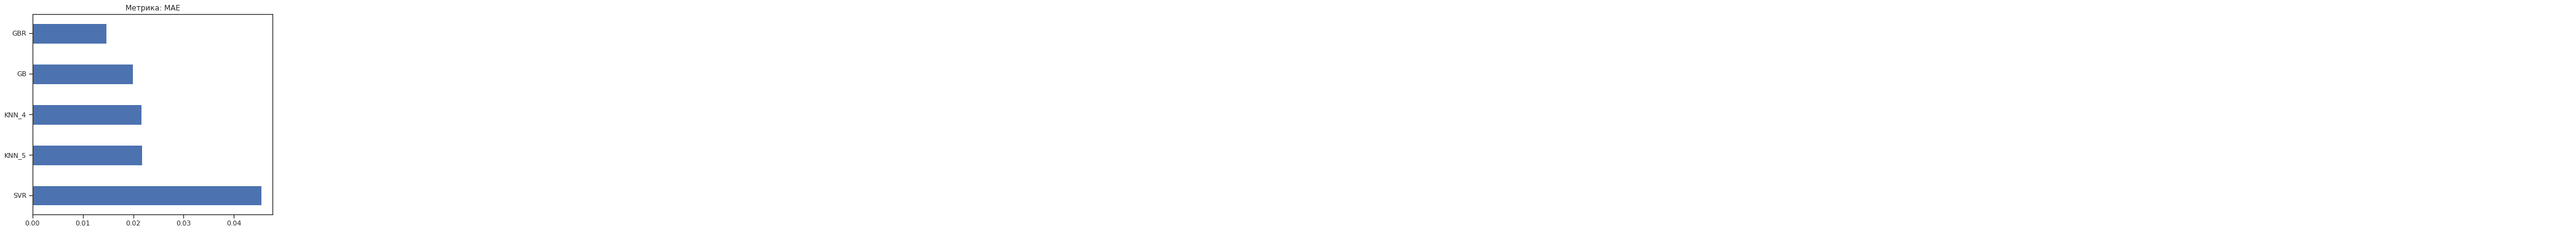

In [46]:
regrMetricLogger.plot('Метрика: ' + 'MAE', 'MAE', ascending=False, figsize=(7, 6))

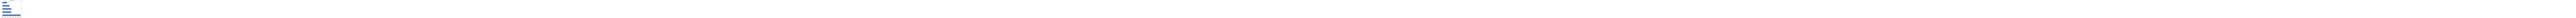

In [50]:
regrMetricLogger.plot('Метрика: ' + 'MSE', 'MSE', ascending=False, figsize=(7, 6))

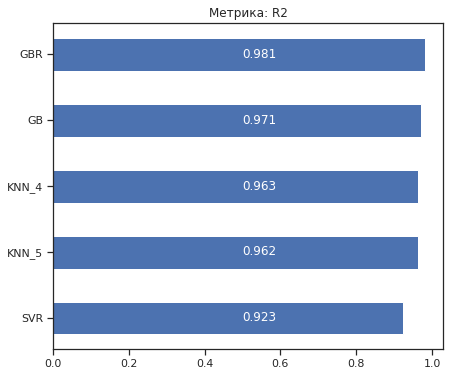

In [48]:
regrMetricLogger.plot('Метрика: ' + 'R2', 'R2', ascending=True, figsize=(7, 6))

Таким образом, для решения данной задачи регрессии хорошо подошла модель градиентного бустинга, так как она является ансамлевой моделью, а также высокую точность обучения обеспечила модель "Машина опорных векторов".